In [1]:
# Installing necessary libraries

!pip install cellpylib

In [2]:
# Importing necessary libraries

import cellpylib as cpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import seaborn as sns
import time
import math
import matplotlib.cm as cm # For colourmap plots later
from tqdm import tqdm

In [71]:
# Optional. Makes the outputs more readable by surpressing certain warnings.

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [92]:
# Parameters

# Data generation parameters
data_size = 100 # the number of data points in each row of data
timesteps = 100 # the number of timesteps which each programme is run for before the output is used to train the model

# Model parameters
num_epochs = 1000  # Number of training epochs #Later move to 1000 epochs
hidden_size = 512  # Update with the desired size of the hidden layer
learning_rate = 0.005 # learning rate used later in the optimizer
batch_size = 128 # Batch size used when creating the train and test datasets. 32 is more suitable for this problem. 
epochs = np.arange(0,num_epochs, 1) # Used in plotting
accuracy_frequency = 10 # Used in the evaluation of the model #Later move to 1. moving_avg will clear up plots

In [93]:
# Define the programme probability distribution, weighting highly autocorrelated programmes more heavily.

def prog_dist_antiweight_autocorr(): # Takes the autocorrelations of programmes, and makes less 
    # autocorrelated programmes more common
    #autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16, 100, 100]
    #programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255] # a fairly random selection. All unique
    autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16]
    programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225]
    prog_list = np.zeros(256)
    for index, item in enumerate(programmes):
        autocorrelation = autocorr[index]
        prog_list[item] = (autocorrelation + 1)**(-1)
    prog_list_norm = [x / sum(prog_list) for x in prog_list]
    return prog_list_norm

def prog_dist_weight_autocorr(): #Make more autocorrelated programmes more common
    #autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16, 100, 100]
    #programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255] # a fairly random selection. All unique
    autocorr = [100, 61.84, 64.8, 62.4, 100, 63.63, 100, 50.3, 52.27, 50.24, 50.2, 48.16]
    programmes = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225]
    prog_list = np.zeros(256)
    for index, item in enumerate(programmes):
        autocorrelation = autocorr[index]
        prog_list[item] = (100 - autocorrelation + 1)**(-1)
    prog_list_norm = [x / sum(prog_list) for x in prog_list]
    return prog_list_norm

programmes_prob_distribution = prog_dist_weight_autocorr()

In [94]:
# Model Initialisation / Training setup

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        return out

# Define the input size, hidden size, and number of classes
input_size = data_size  # Update with the actual input size
num_classes = 256 #Number of potential classes, here stuck at 256
#num_classes = 12

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [95]:
# Define a way to reset weights

def reset_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            module.reset_parameters()

In [96]:
# Data generation functions (where the programmes_considered have a probability distribution)

def create_data(data_size, programmes_prob_distribution, number_of_samples, timesteps):

    # Creating the dataset and labels variables to be populated later
    dataset = np.empty(shape=(number_of_samples, data_size), dtype=int) # each row is data_size length, with number_of_samples rows
    labels = np.empty(shape=(1, number_of_samples), dtype=int)

    # Stating the space of considered programmes
    programmes = np.arange(0,256,1)

    # Normalising the distribution in case it is not already normalised
    programmes_total = sum(programmes_prob_distribution)
    programmes_prob_distribution_norm = [x / programmes_total for x in programmes_prob_distribution]
    
    for i in range(number_of_samples):

        # Randomly selecting a rule number according to the probability distribution given
        rule_number = np.random.choice(a = programmes, size=None, replace=True, p = programmes_prob_distribution_norm)
        #print(f"Considering rule_number = ", rule_number)
        cellular_automaton = cpl.init_random(data_size)
        cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
        #print(cellular_automaton[-1])
        dataset[i] = cellular_automaton[-1]
        labels[:,i] = rule_number

    return [dataset, labels]

def data_loader(data_size, programmes_prob_distribution, number_of_samples, timesteps):

    # Generate the data according to input parameters
    [dataset, labels] = create_data(data_size, programmes_prob_distribution, number_of_samples, timesteps)
    labels = labels[0] # Deal with the fact that the output is a list of a single list

    # Shifting the labels such that they are indexed from 0. Required for cross entropy to work
    #labels = [x - min(labels) for x in labels] #!!! Not currently shifting labels in a test to alter them later - may help with training in smaller batches
    # Use data_split
    data = [(data_sample, label) for data_sample, label in zip(dataset, labels)]

    train_dataset, train_labels = zip(*data)
    
    tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
    
    train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader

In [97]:
# Evaluates a model over the space of all possible functions. Outputs a vector giving that performance

def model_evaluation(model, data_size, timesteps, batch_size):

    # State which programmes are being considered. In this case, it's all of them.
    #programmes_considered = np.arange(0,256,1) #NOTE: THIS DISABLING IS TEMPORARY. AIM TO REINTRODUCE IT
    programmes_considered = np.array([0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]) # The programmes used at the moment in autocorrelation

    accuracy_vector = np.empty(256)
    
    for programme in programmes_considered:

        programmes_prob_distribution = [0]*256
        programmes_prob_distribution[programme] = 1

        train_loader = data_loader(data_size, programmes_prob_distribution, batch_size, timesteps)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for data, labels in train_loader:
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            accuracy = 100 * correct / total #returns the accuracy as a percentage
            #print(f"For programme " + str(programme) + ": Accuracy = " + str(accuracy))
        accuracy_vector[programme] = accuracy
                
    return accuracy_vector

In [98]:
# Training loop (includes data generation). Note that here training and test loss cease to make much sense

def main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs):

    # Initisalise training and test loss tracking variables
    training_loss = np.empty(num_epochs)

    # Initialise an array to track not only the general training and test loss, but also the accuracy on individual programme classification during training.
    # This is to attempt to see grokking.
    # Form: Each row of accuracy_array is an epoch, each column of accuracy_array is a binary 1 or 0 based on whether or not it was correctly classified. 
    #accuracy_frequency = 100 # Once every 100 epochs, the accuracy is measured
    accuracy_array = np.empty((math.floor(num_epochs/accuracy_frequency), 256))
    # Initialising variaable for tracking where in the accuracy_array to write data
    eval_count = 0
    # Each epoch here trains over 1 batch size of data (which at the moment is 32). Each epoch is therefore smaller and better controlled.
    for epoch in tqdm(range(num_epochs)):

        # Continually monitoring accuracy of the model by adjusting the accuracy_array
        if epoch%accuracy_frequency==0:
            accuracy_vector = model_evaluation(model, data_size, timesteps, batch_size)
            accuracy_array[eval_count] = accuracy_vector
            eval_count += 1
        
        train_loader = data_loader(data_size, programmes_prob_distribution, batch_size, timesteps)
        for data, labels in train_loader:
            # Forward pass
            outputs = model(data)
    
            #Shifting labels for loss calculation
            shifted_labels = labels - torch.min(labels)
            shifted_labels = shifted_labels.long()
            loss = criterion(outputs, shifted_labels)
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print the loss after each epoch
        if epoch%100==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
        training_loss[epoch] = loss.item()

    return [training_loss, accuracy_array]

In [99]:
#[training_loss, accuracy_array] = main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs)

In [100]:
def accuracy_plot(ax, moving_avg, num_epochs, rel_list, repeat_idx, accuracy_array):
    
    print(f'moving average = ', moving_avg)
    
    epochs = np.arange(1, num_epochs - num_epochs%moving_avg + 1,1)

    rel_array = np.array(rel_list)
    #lines_plotted = uncorr_array[0:3]
    #lines_plotted = rel_array[2: 5]
    uncorr_array = rel_array
    lines_plotted = rel_array

    rel_epochs = [x for x, index in enumerate(epochs) if index%accuracy_frequency==0]

    # Create an axis object for the line plot
    cmap = cm.get_cmap('rainbow')  # You can choose different colormaps

    # Taking values from nearby epochs and averaging
    reshaped_epochs = np.reshape(rel_epochs, (-1, moving_avg))
    filtered_epochs = reshaped_epochs[:,0]
    repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

    for i in tqdm(lines_plotted):
        line = accuracy_array[:,i]
        #color = cmap(lines_plotted[np.where(lines_plotted==i)[0][0]] / (len(lines_plotted) - 1))
        #color = cmap(index / (len(lines_plotted) - 1))
        color = cmap(np.where(lines_plotted == i)[0][0] / (len(lines_plotted) - 1))
        reshaped_line = np.reshape(line, (-1, moving_avg))
        programme_label = 'Programme: ' + str(uncorr_array[np.where(lines_plotted==i)][0])
        pandas_df = pd.DataFrame({programme_label: reshaped_line.flatten(), 'Epochs': repeated_filtered_epochs})
        pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = [programme_label], var_name='line', value_name = 'Values')
        #fig, ax = plt.subplots()
        sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line', ax=ax, palette = [color])

    # Create a ScalarMappable object for the colorbar
    norm = plt.Normalize(0, len(lines_plotted) - 1)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # Set an empty array to associate with the colorbar
    cbar = plt.colorbar(sm, ax=ax)

    cbar.set_label('Program Number')

    num_ticks = len(lines_plotted)  # Number of desired ticks
    indices = np.linspace(0, len(lines_plotted) - 1, num_ticks, dtype=int)
    tick_positions = indices
    tick_labels = lines_plotted[indices]

    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(tick_labels)

    ax.get_legend().remove()

    ax.set_ylabel('Accuracy (%)')

  0%|          | 1/1000 [00:31<8:40:31, 31.26s/it]

Epoch [1/1000], Loss: 5.572414398193359


 10%|█         | 101/1000 [08:27<3:20:06, 13.36s/it]

Epoch [101/1000], Loss: 5.10538911819458


 20%|██        | 201/1000 [16:34<1:53:28,  8.52s/it]

Epoch [201/1000], Loss: 4.487478733062744


 30%|███       | 301/1000 [23:19<1:38:42,  8.47s/it]

Epoch [301/1000], Loss: 3.3828723430633545


 40%|████      | 401/1000 [29:46<1:25:06,  8.52s/it]

Epoch [401/1000], Loss: 2.0229413509368896


 50%|█████     | 501/1000 [36:08<1:10:37,  8.49s/it]

Epoch [501/1000], Loss: 1.698624610900879


 60%|██████    | 601/1000 [42:30<55:55,  8.41s/it]  

Epoch [601/1000], Loss: 1.506600022315979


 70%|███████   | 701/1000 [48:55<42:01,  8.43s/it]

Epoch [701/1000], Loss: 1.6223081350326538


 80%|████████  | 801/1000 [55:19<28:24,  8.56s/it]

Epoch [801/1000], Loss: 1.4385995864868164


 90%|█████████ | 901/1000 [1:01:42<13:47,  8.36s/it]

Epoch [901/1000], Loss: 1.480934739112854


100%|██████████| 1000/1000 [1:07:41<00:00,  4.06s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_6208\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


  0%|          | 1/1000 [00:23<6:37:55, 23.90s/it]

Epoch [1/1000], Loss: 5.017027378082275


 10%|█         | 101/1000 [07:26<2:53:22, 11.57s/it]

Epoch [101/1000], Loss: 3.167598009109497


 20%|██        | 201/1000 [15:15<2:40:02, 12.02s/it]

Epoch [201/1000], Loss: 1.8605016469955444


 30%|███       | 301/1000 [23:27<2:07:39, 10.96s/it]

Epoch [301/1000], Loss: 1.6586498022079468


 40%|████      | 401/1000 [31:41<1:50:28, 11.07s/it]

Epoch [401/1000], Loss: 1.5133278369903564


 50%|█████     | 501/1000 [40:24<1:57:17, 14.10s/it]

Epoch [501/1000], Loss: 1.4808241128921509


 60%|██████    | 601/1000 [49:33<1:21:21, 12.23s/it]

Epoch [601/1000], Loss: 1.3178722858428955


 70%|███████   | 701/1000 [59:19<1:06:54, 13.43s/it]

Epoch [701/1000], Loss: 1.222510576248169


 80%|████████  | 801/1000 [1:08:39<44:36, 13.45s/it]  

Epoch [801/1000], Loss: 1.2296264171600342


 90%|█████████ | 901/1000 [1:17:28<19:14, 11.66s/it]

Epoch [901/1000], Loss: 1.2872142791748047


100%|██████████| 1000/1000 [1:25:46<00:00,  5.15s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_6208\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


  0%|          | 1/1000 [00:31<8:51:37, 31.93s/it]

Epoch [1/1000], Loss: 4.740838527679443


 10%|█         | 101/1000 [10:06<2:57:05, 11.82s/it]

Epoch [101/1000], Loss: 2.0690107345581055


 20%|██        | 201/1000 [18:53<2:29:23, 11.22s/it]

Epoch [201/1000], Loss: 1.6327736377716064


 30%|███       | 301/1000 [27:35<2:14:11, 11.52s/it]

Epoch [301/1000], Loss: 1.4793764352798462


 40%|████      | 401/1000 [36:07<1:51:39, 11.18s/it]

Epoch [401/1000], Loss: 1.5069602727890015


 50%|█████     | 501/1000 [45:16<1:46:59, 12.86s/it]

Epoch [501/1000], Loss: 1.52921462059021


 60%|██████    | 601/1000 [54:30<1:18:27, 11.80s/it]

Epoch [601/1000], Loss: 1.4612312316894531


 70%|███████   | 701/1000 [1:03:41<59:23, 11.92s/it]  

Epoch [701/1000], Loss: 1.193575143814087


 80%|████████  | 801/1000 [3:15:40<35:15, 10.63s/it]      

Epoch [801/1000], Loss: 1.3205716609954834


 90%|█████████ | 901/1000 [3:25:35<16:35, 10.06s/it]

Epoch [901/1000], Loss: 1.3834848403930664


100%|██████████| 1000/1000 [3:32:56<00:00, 12.78s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_6208\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


  0%|          | 1/1000 [00:29<8:03:36, 29.05s/it]

Epoch [1/1000], Loss: 4.47401237487793


 10%|█         | 101/1000 [08:08<2:33:19, 10.23s/it]

Epoch [101/1000], Loss: 1.8737001419067383


 20%|██        | 201/1000 [15:53<2:14:32, 10.10s/it]

Epoch [201/1000], Loss: 1.6489558219909668


 30%|███       | 301/1000 [23:52<1:58:23, 10.16s/it]

Epoch [301/1000], Loss: 1.47291100025177


 40%|████      | 401/1000 [31:39<1:44:42, 10.49s/it]

Epoch [401/1000], Loss: 1.4533076286315918


 50%|█████     | 501/1000 [39:19<1:24:20, 10.14s/it]

Epoch [501/1000], Loss: 1.3467825651168823


 60%|██████    | 601/1000 [47:09<1:07:38, 10.17s/it]

Epoch [601/1000], Loss: 1.3556722402572632


 70%|███████   | 701/1000 [54:48<50:58, 10.23s/it]  

Epoch [701/1000], Loss: 1.2669304609298706


 80%|████████  | 801/1000 [1:02:27<33:43, 10.17s/it]

Epoch [801/1000], Loss: 1.3539775609970093


 90%|█████████ | 901/1000 [1:10:05<17:27, 10.58s/it]

Epoch [901/1000], Loss: 1.4010924100875854


100%|██████████| 1000/1000 [1:17:15<00:00,  4.64s/it]
C:\Users\plogo\AppData\Local\Temp\ipykernel_6208\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  1


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


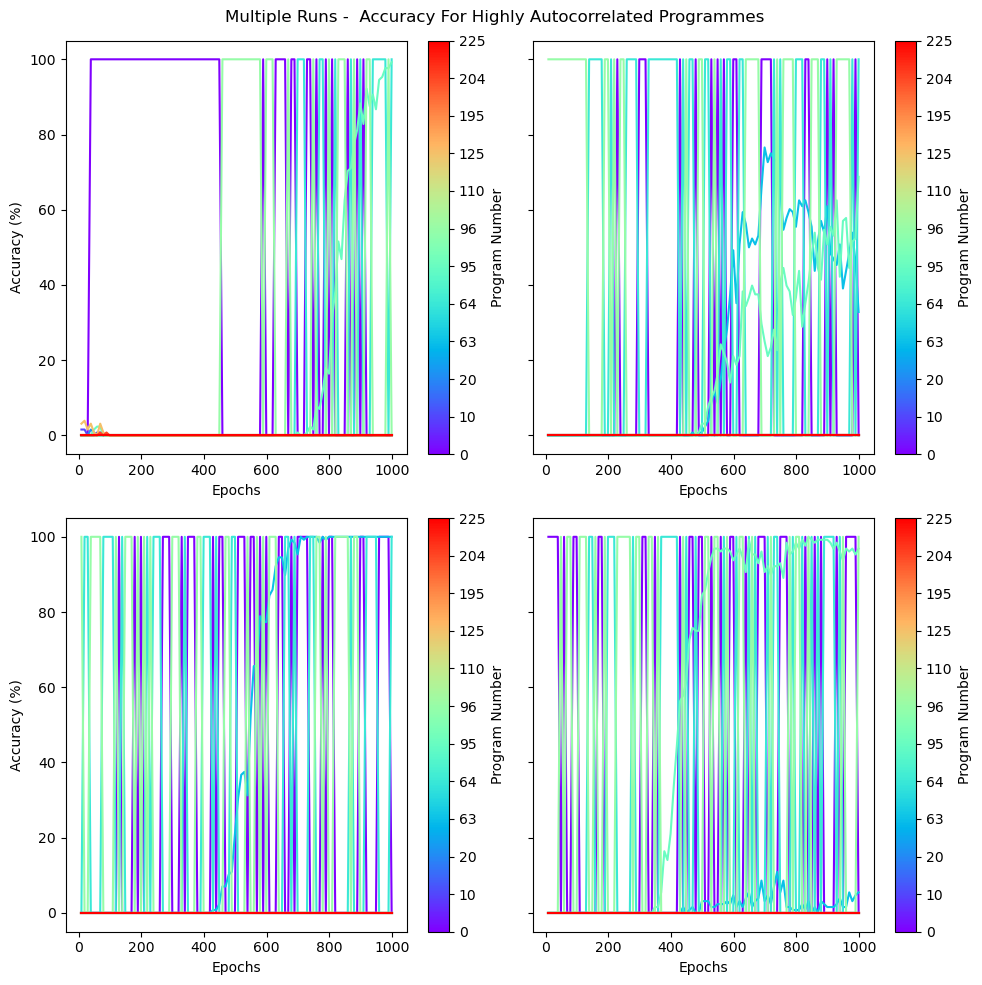

In [101]:
# Creating subplots for different runs    
    
#rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225, 249, 255]
rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225]
num_repeats = 4 # Must be even, sorry
moving_avg = 1
fig, axs = plt.subplots(2, int(num_repeats/2), figsize=(5*(int(num_repeats/2)),5*(int(num_repeats/2))), sharey='row')
training_loss_list = []
accuracy_array_list = []
for repeat_idx in range(num_repeats):
    reset_weights(model)
    [training_loss, accuracy_array] = main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs)
    training_loss_list.append(training_loss)
    accuracy_array_list.append(accuracy_array)
    accuracy_plot(axs[repeat_idx // (num_repeats//2), repeat_idx % (num_repeats//2)], moving_avg, num_epochs, rel_list, repeat_idx, accuracy_array)
    
plt.suptitle('Multiple Runs -  Accuracy For Highly Autocorrelated Programmes')
plt.tight_layout()
plt.show()  

In [102]:
# Pickle the results of the above calculation to avoid unneccesary corruption

import pickle

# Save training_loss_list to a file
with open('training_loss_list_autocorr.pkl', 'wb') as f:
    pickle.dump(training_loss_list, f)
    
# Saving accuracy array
with open('accuracy_array_list_autocorr.pkl', 'wb') as f:
    pickle.dump(accuracy_array_list, f)

If the above code works as expected, and gives desirable results, then it will be repeated almost verbatim for the reversed case of when autocorrelation is negatively weighted (which I expect to give more interpretable results). Note that all of the data from this run is being carefully saved (and should probably be pickled) to allow for easy formatting changes.

In addition, this code should allow for Hierarhical clustering to be run. The larger number of progammes there might present an issue, but I expect it would be fine. Then, runnning the reverse version would give me four plots and potentially a clear case for correlation in learning algorithm design.

C:\Users\plogo\AppData\Local\Temp\ipykernel_6208\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  5


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]
C:\Users\plogo\AppData\Local\Temp\ipykernel_6208\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  5


100%|██████████| 12/12 [00:10<00:00,  1.18it/s]
C:\Users\plogo\AppData\Local\Temp\ipykernel_6208\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  5


100%|██████████| 12/12 [00:10<00:00,  1.15it/s]
C:\Users\plogo\AppData\Local\Temp\ipykernel_6208\1564914665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  # You can choose different colormaps


moving average =  5


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


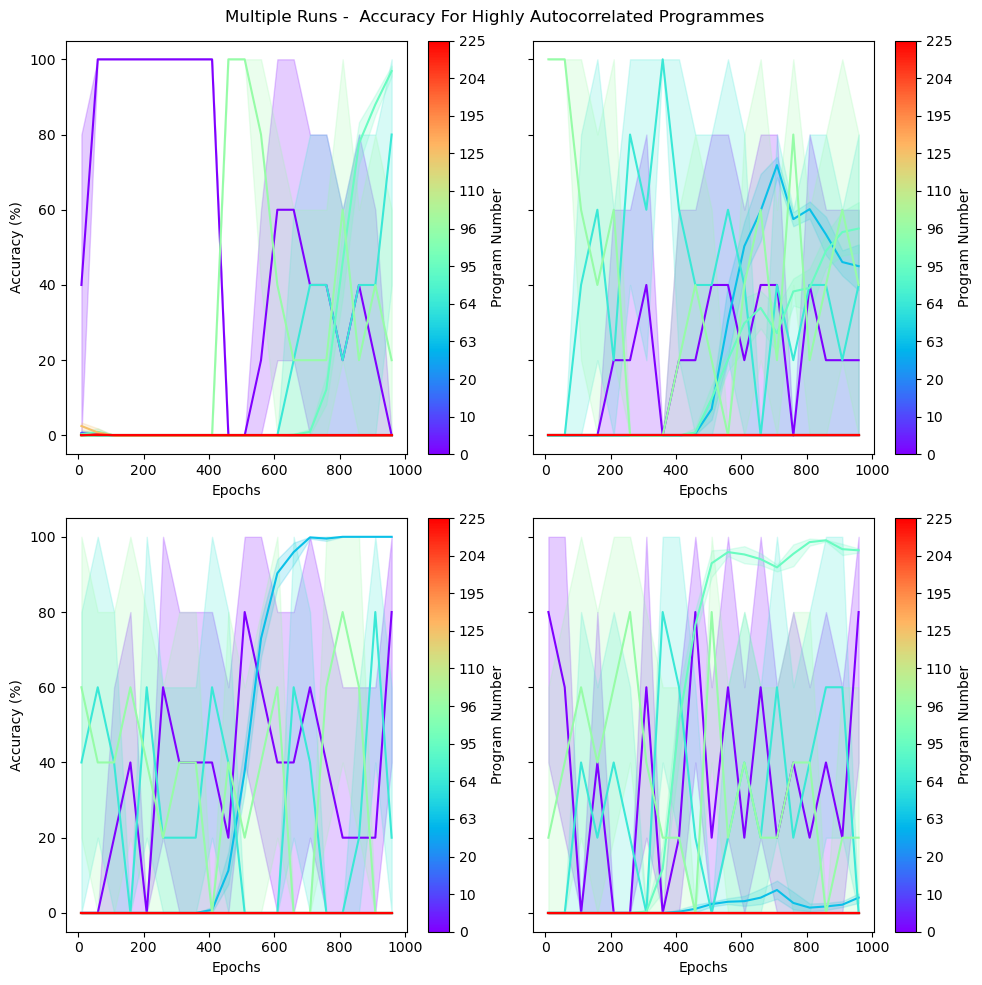

In [103]:
# Repeating the above plot, but with a higher moving average

rel_list = [0, 10, 20, 63, 64, 95, 96, 110, 125, 195, 204, 225]
num_repeats = 4 # Must be even, sorry
moving_avg = 5
fig, axs = plt.subplots(2, int(num_repeats/2), figsize=(5*(int(num_repeats/2)),5*(int(num_repeats/2))), sharey='row')
for repeat_idx in range(num_repeats):
    #reset_weights(model)
    #[training_loss, accuracy_array] = main_train(data_size, programmes_prob_distribution, batch_size, timesteps, num_epochs)
    #training_loss_list.append(training_loss)
    #accuracy_array_list.append(accuracy_array)
    accuracy_array = accuracy_array_list[repeat_idx]
    accuracy_plot(axs[repeat_idx // (num_repeats//2), repeat_idx % (num_repeats//2)], moving_avg, num_epochs, rel_list, repeat_idx, accuracy_array)
    
plt.suptitle('Multiple Runs -  Accuracy For Highly Autocorrelated Programmes')
plt.tight_layout()
plt.show()  